<a href="https://colab.research.google.com/github/kashishthakur26/Tensorflow-learning/blob/main/introduction_to_NLP_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to NLP fundamentals in Tensorflow 

NLP has the goal of deriving information out of natural language(could be sequences text or speech).

Another common term for NLP problems is sequence to sequence problems.(seq2seq).

In [1]:
import sys
sys.path.append('/content/drive/MyDrive/Colab-notebooks')

In [2]:
import helper_function


In [3]:
from helper_function import unzip_data , create_tensorboard_callback , plot_loss_curves  , compare_historys

## Get a text dataset

The dataset we're going to be using is Kaggle's introduction to NLP dataset (text samples of tweets labelled as disaster or not disaster.)

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

--2023-06-08 15:24:36--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.23.128, 74.125.203.128, 74.125.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.23.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K   956KB/s    in 0.6s    

2023-06-08 15:24:37 (956 KB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [5]:
unzip_data('nlp_getting_started.zip')

## visualize a text data

In [6]:
import pandas as pd

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
train_df_shuffled = train_df.sample(frac=1,random_state=42)

train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [8]:
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [9]:
# Let's visualize some random training examples
import random
random_index = random.randint(0,len(train_df)-5)

for row in train_df_shuffled[["text","target"]][random_index:random_index+5].itertuples():
  _,text , target = row
  print(f"Target: {target}","(real diaster)" if target > 0 else "(not real disaster)")

  print(f"Text:\n{text}\n")
  print("____\n")

Target: 0 (not real disaster)
Text:
Why did God order obliteration of ancient Canaanites? http://t.co/NckOgWjq61 via @worldnetdaily

____

Target: 1 (real diaster)
Text:
Consent Order on cleanup underway at CSX derailment site - Knoxville News Sentinel http://t.co/xsZx9MWXYp http://t.co/NMFsgKf1Za

____

Target: 1 (real diaster)
Text:
5/6 will destroy Reg C competitiveness.   The entire region will B over-saturated.   Yes Brockton gets $12M and RegC Commonwealth PPC and

____

Target: 0 (not real disaster)
Text:
These boxes are ready to explode! Exploding Kittens finally arrived! gameofkittens #explodingkittensÛ_ https://t.co/TFGrAyuDC5

____

Target: 1 (real diaster)
Text:
Suicide bomber kills 15 in Saudi security site mosque - Reuters http://t.co/37DqvJHNCv

____



## Split data into training and validation sets


In [10]:
from sklearn.model_selection import train_test_split

train_sentences , val_sentences , train_labels , val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                               train_df_shuffled["target"].to_numpy(),
                                                                               test_size=0.1,
                                                                               random_state=42)

In [11]:
len(train_sentences), len(train_labels) , len(val_sentences) , len(val_labels)

(6851, 6851, 762, 762)

## Converting text into numbers
When dealing with a text problem, one of the first things you'll have to do before you can build a model is to convert your text to numbers.and

There are a few  ways ton do this,namely:
* Tokenziation - direct mapping of token (a token could be a word or a character) to a number
* Embedding - create a matrix of feature vector fro each token(the size of the feature vector can be defined and this embedding can be learned)

In [12]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

tex_vectorizer = TextVectorization(max_tokens=15,
                                   standardize="lower_and_strip_punctuation",
                                   split="whitespace",
                                   ngrams=None,
                                   output_mode="int",
                                   output_sequence_length=None,
                                   pad_to_max_tokens=True)

In [13]:
max_vocab_length = 10000
max_length = 15

In [14]:
text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [15]:
# Fitting the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [16]:
train_sentences[:10]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk',
       '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
       'destroy the free fandom honestly',
       'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
       '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
       'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
      dtype=object)

In [17]:
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]

In [18]:
print(top_5_words)
print(bottom_5_words)

['', '[UNK]', 'the', 'a', 'in']
['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


## Creating an embedding using an embedding layer

The parameters we care most about fro our embedding layer:
* 'input_dim' = the size of our vocabulary
* 'output_dim' = the size of the output embedding vector
* 'input_length' = length of the sequences being passsed to the embedding layer

In [19]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             input_length=max_length)

embedding

In [20]:
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\\n \n embedded version: ")

sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
 #world FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps  http://t.co/wvExJjRG6E\n 
 embedded version: 


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.01844621,  0.04147987, -0.00745906, ...,  0.02339916,
          0.04044778,  0.01968993],
        [-0.02603498, -0.03384151,  0.02812668, ..., -0.04545777,
          0.03842529, -0.00780561],
        [-0.02015969, -0.02793921,  0.00750823, ...,  0.02951245,
          0.01909632,  0.04709886],
        ...,
        [-0.00084251,  0.0435415 ,  0.04365816, ..., -0.02955669,
         -0.03004065, -0.03700126],
        [ 0.0237132 , -0.00733339,  0.02966753, ..., -0.0374577 ,
          0.03780964, -0.02909195],
        [ 0.02862218, -0.03479362,  0.0072422 , ...,  0.01686502,
         -0.01624651, -0.00381633]]], dtype=float32)>

## Model 0 : Naive Bayes (baseline model)

As with all machine learning modelling experiments, it's important to create a baseline model so you've got a benchmark for future experiments to build upon.


To create our baseline, we'll use Sklearn's Mutlinomial Naive BAyes using the TF-IDF fromula to convert our words to numbers. 

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
     ("tfidf",TfidfVectorizer()),
     ("clf",MultinomialNB())
])

model_0.fit(train_sentences , train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [22]:
baseline_score = model_0.score(val_sentences , val_labels)

In [23]:
print(baseline_score*100)

79.26509186351706


## creating an evaluation fucntion for our model experiments

We could evaluate all of our model's predictions with different metrics every time...

Let's create one to compare our model's predictions with the truth labels using the following metrics:

* Accuracy
* Precision
* Recall
* F1-score


In [24]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results
  


In [25]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [26]:
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [27]:
## Model 1: A simple dense model

In [28]:
from helper_function import create_tensorboard_callback

SAVE_DIR = "model_logs"

In [29]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") 
x = text_vectorizer(inputs)
x = embedding(x) 
x = layers.GlobalAveragePooling1D()(x) 
outputs = layers.Dense(1, activation="sigmoid")(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [30]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [31]:
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [32]:
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences , val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20230608-152443
Epoch 1/5
215/215 [==============================] - 29s 101ms/step - loss: 0.6129 - accuracy: 0.6939 - val_loss: 0.5385 - val_accuracy: 0.7559
Epoch 2/5
215/215 [==============================] - 4s 17ms/step - loss: 0.4430 - accuracy: 0.8183 - val_loss: 0.4722 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3482 - accuracy: 0.8593 - val_loss: 0.4639 - val_accuracy: 0.7913
Epoch 4/5
215/215 [==============================] - 2s 7ms/step - loss: 0.2854 - accuracy: 0.8860 - val_loss: 0.4622 - val_accuracy: 0.7835
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.2391 - accuracy: 0.9101 - val_loss: 0.4782 - val_accuracy: 0.7795


In [33]:
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4782 - accuracy: 0.7795


[0.4782062768936157, 0.7795275449752808]

In [34]:
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

24/24 [==============================] - 0s 2ms/step


(762, 1)

In [35]:
model_1_pred_probs[0]

array([0.3230444], dtype=float32)

In [36]:
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [37]:
model_1_results = calculate_results(y_true = val_labels,
                                    y_pred = model_1_preds)

In [38]:
model_1_results

{'accuracy': 77.95275590551181,
 'precision': 0.7816545659065345,
 'recall': 0.7795275590551181,
 'f1': 0.7774022539420016}

In [39]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [40]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

 ## Visualizing learning embeddings

In [41]:
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab) , words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [42]:
embed_weights = model_1.get_layer("embedding").get_weights()[0]
embed_weights.shape

(10000, 128)

In [43]:
import io

In [44]:
import io

# Create output writers
out_v = io.open("embedding_vectors.tsv", "w", encoding="utf-8")
out_m = io.open("embedding_metadata.tsv", "w", encoding="utf-8")

# Write embedding vectors and words to file
for num, word in enumerate(words_in_vocab):
  if num == 0: 
     continue # skip padding token
  vec = embed_weights[num]
  out_m.write(word + "\n") # write words to file
  out_v.write("\t".join([str(x) for x in vec]) + "\n") # write corresponding word vector to file
out_v.close()
out_m.close()

# Download files locally to upload to Embedding Projector
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download("embedding_vectors.tsv")
  files.download("embedding_metadata.tsv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Model 2: LSTM

LSTM = long short term memory (one of the most popular LSTM cells)

Our structure of an RNN typically looks like this:

Input (text) -> Tokenize -> Embedding -> layers(RNNs/dense) -> Output (label probability)

In [45]:
# Create an LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# print(x.shape)
#  x = layers.LSTM(64, return_sequences=True)(x)
# print(x.shape)
x = layers.LSTM(64)(x)
# print(x.shape)
# x = layers.Dense(64 , activation="relu")(x)
# print(x.shape)
outputs = layers.Dense(1 , activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs , outputs , name="model_2_LSTM")


In [46]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [47]:
# Compile the model

model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics="accuracy")

model_2_history = model_2.fit(train_sentences,
                              train_labels,
                               epochs =5,
                             validation_data = (val_sentences , val_labels),
                callbacks=[create_tensorboard_callback(SAVE_DIR,"mode_2_LSTM")])

Saving TensorBoard log files to: model_logs/mode_2_LSTM/20230608-152526
Epoch 1/5
215/215 [==============================] - 15s 55ms/step - loss: 0.2273 - accuracy: 0.9193 - val_loss: 0.5751 - val_accuracy: 0.7782
Epoch 2/5
215/215 [==============================] - 3s 16ms/step - loss: 0.1563 - accuracy: 0.9421 - val_loss: 0.6114 - val_accuracy: 0.7756
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.1294 - accuracy: 0.9489 - val_loss: 0.7565 - val_accuracy: 0.7848
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.1039 - accuracy: 0.9613 - val_loss: 0.8478 - val_accuracy: 0.7848
Epoch 5/5
215/215 [==============================] - 2s 7ms/step - loss: 0.0848 - accuracy: 0.9664 - val_loss: 0.8884 - val_accuracy: 0.7769


In [48]:
# MAke predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


array([[0.08431249],
       [0.7426369 ],
       [0.9998135 ],
       [0.09585651],
       [0.00130208],
       [0.9995048 ],
       [0.8570287 ],
       [0.9998902 ],
       [0.9998079 ],
       [0.7442713 ]], dtype=float32)

In [49]:
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [50]:
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 77.69028871391076,
 'precision': 0.7768730242711755,
 'recall': 0.7769028871391076,
 'f1': 0.7759702290700327}

### Model 3 : GRU

Another popular abad effective RNN component is the GRU or gated recurrent unit.
The GRU call has similar features to an LSTM cell but has less parameters.

In [51]:
tf.random.set_seed(42)
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
# x = layers.GRU(64, return_sequences=True) # stacking recurrent cells requires return_sequences=True
x = layers.GRU(64)(x) 
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [52]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [53]:
# compiling 
model_3.compile(loss="binary_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [54]:

model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20230608-152552
Epoch 1/5
215/215 [==============================] - 15s 61ms/step - loss: 0.5272 - accuracy: 0.7272 - val_loss: 0.4612 - val_accuracy: 0.7730
Epoch 2/5
215/215 [==============================] - 2s 12ms/step - loss: 0.3202 - accuracy: 0.8682 - val_loss: 0.4918 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.2192 - accuracy: 0.9174 - val_loss: 0.5653 - val_accuracy: 0.7664
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.1581 - accuracy: 0.9450 - val_loss: 0.6251 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 3s 13ms/step - loss: 0.1183 - accuracy: 0.9600 - val_loss: 0.6206 - val_accuracy: 0.7690


In [55]:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

24/24 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [56]:
model_3_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 76.9028871391076,
 'precision': 0.7686779209417003,
 'recall': 0.7690288713910761,
 'f1': 0.7684200226242667}

## Bidirectional RNN model

Model 4

In [57]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64 ))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs , outputs , name="model_4_bidirectional")


In [58]:
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

In [59]:
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [60]:
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences , val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20230608-152636
Epoch 1/5
215/215 [==============================] - 16s 52ms/step - loss: 0.1311 - accuracy: 0.9596 - val_loss: 0.7670 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0771 - accuracy: 0.9699 - val_loss: 0.9642 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0589 - accuracy: 0.9733 - val_loss: 1.2612 - val_accuracy: 0.7651
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0521 - accuracy: 0.9752 - val_loss: 1.2460 - val_accuracy: 0.7664
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0459 - accuracy: 0.9777 - val_loss: 1.5215 - val_accuracy: 0.7703


In [61]:
  model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 3ms/step


array([[5.8882200e-04],
       [6.3941169e-01],
       [9.9998498e-01],
       [7.9717673e-02],
       [1.3151981e-05],
       [9.9996758e-01],
       [9.9930370e-01],
       [9.9999297e-01],
       [9.9998367e-01],
       [9.9855918e-01]], dtype=float32)

In [62]:
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [63]:
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 77.03412073490814,
 'precision': 0.7705174165815669,
 'recall': 0.7703412073490814,
 'f1': 0.7691322758419059}

In [64]:
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(baseline_results=baseline_results, 
                                new_model_results=model_1_results)

Baseline accuracy: 79.27, New accuracy: 77.95, Difference: -1.31
Baseline precision: 0.81, New precision: 0.78, Difference: -0.03
Baseline recall: 0.79, New recall: 0.78, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.01


In [65]:
compare_baseline_to_new_results(baseline_results, model_4_results)

Baseline accuracy: 79.27, New accuracy: 77.03, Difference: -2.23
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


## Convolution neural networks for text (and other types of sequences)

we've udes CNNs for images but images are typically 2D (height x width).... however, our text data is 1D.

Previously we've Conv2D fro our image data but mow we're going to use Conv1D.

Inputs (text) -> Tokenization -> Embedding -> Layer(s)(Conv1D +pooling) -> outputs(class probabilities)

In [66]:
from tensorflow.keras import layers

In [68]:
embedding_test = embedding(text_vectorizer(["this is a test sentence"]))
conv_1D = layers.Conv1D(filters=32,
                        kernel_size=5,
                        activation="relu",
                        padding="valid")

conv_1D_output = conv_1D(embedding_test)
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1D_output)

In [72]:
tf.random.set_seed(42)
from tensorflow.keras import layers
model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_5")

# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile Conv1D model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our 1D convolution model
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_5 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d_3 (Conv1D)           (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d_3 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 1)              

In [73]:

model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20230608-160221
Epoch 1/5
215/215 [==============================] - 14s 50ms/step - loss: 0.5650 - accuracy: 0.7187 - val_loss: 0.4655 - val_accuracy: 0.7808
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.3412 - accuracy: 0.8599 - val_loss: 0.4648 - val_accuracy: 0.7953
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.2119 - accuracy: 0.9234 - val_loss: 0.5252 - val_accuracy: 0.7651
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.1354 - accuracy: 0.9564 - val_loss: 0.6074 - val_accuracy: 0.7717
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0954 - accuracy: 0.9689 - val_loss: 0.6619 - val_accuracy: 0.7861


In [74]:
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


array([[0.6248684 ],
       [0.6954278 ],
       [0.9998029 ],
       [0.06961489],
       [0.0018764 ],
       [0.9941907 ],
       [0.928893  ],
       [0.99736315],
       [0.99952495],
       [0.3164259 ]], dtype=float32)

In [75]:
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [76]:
model_5_results = calculate_results(y_true = val_labels,
                                    y_pred = model_5_preds)

In [77]:
model_5_results 

{'accuracy': 78.60892388451444,
 'precision': 0.7899352475221245,
 'recall': 0.7860892388451444,
 'f1': 0.7834372696728737}

In [80]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [78]:
compare_baseline_to_new_results(baseline_results , model_5_results)

Baseline accuracy: 79.27, New accuracy: 78.61, Difference: -0.66
Baseline precision: 0.81, New precision: 0.79, Difference: -0.02
Baseline recall: 0.79, New recall: 0.79, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.00


In [79]:
import numpy as np
np.array(list(model_5_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

## Model 6 - transfer learning (using USE model)

In [84]:
import tensorflow_hub as hub

In [85]:
 sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")


In [89]:
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1 , activation="sigmoid")

],name="model_6_USE")

# Compile
model_6.compile(loss="binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 64)                32832     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [90]:

model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20230608-172259
Epoch 1/5
215/215 [==============================] - 9s 14ms/step - loss: 0.5060 - accuracy: 0.7827 - val_loss: 0.4463 - val_accuracy: 0.7953
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4147 - accuracy: 0.8164 - val_loss: 0.4346 - val_accuracy: 0.8136
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.3996 - accuracy: 0.8215 - val_loss: 0.4307 - val_accuracy: 0.8123
Epoch 4/5
215/215 [==============================] - 4s 18ms/step - loss: 0.3923 - accuracy: 0.8267 - val_loss: 0.4270 - val_accuracy: 0.8150
Epoch 5/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3863 - accuracy: 0.8301 - val_loss: 0.4287 - val_accuracy: 0.8163


In [91]:
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 17ms/step


array([[0.14591837],
       [0.7471367 ],
       [0.990194  ],
       [0.20944117],
       [0.72066593],
       [0.69626546],
       [0.98383015],
       [0.97924346],
       [0.9302674 ],
       [0.08984239]], dtype=float32)

In [92]:
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 1., 0., 1.], dtype=float32)>

In [95]:
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 81.62729658792651,
 'precision': 0.8187546712946793,
 'recall': 0.8162729658792651,
 'f1': 0.8147089025083661}

In [96]:
compare_baseline_to_new_results(baseline_results, model_6_results)

Baseline accuracy: 79.27, New accuracy: 81.63, Difference: 2.36
Baseline precision: 0.81, New precision: 0.82, Difference: 0.01
Baseline recall: 0.79, New recall: 0.82, Difference: 0.02
Baseline f1: 0.79, New f1: 0.81, Difference: 0.03


### Model 7: TensorFlow Hub Pretrained Sentence Encoder 10% of the training datam

In [97]:
train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(np.array(train_sentences),
                                                                                                                            train_labels,
                                                                                                                            test_size=0.1,
                                                                                                                            random_state=42)


In [98]:
model_7 = tf.keras.models.clone_model(model_6)
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
#fitting
# Fit the model to 10% of the training data
model_7_history = model_7.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "10_percent_tf_hub_sentence_encoder")])


Saving TensorBoard log files to: model_logs/10_percent_tf_hub_sentence_encoder/20230608-172702
Epoch 1/5
22/22 [==============================] - 4s 63ms/step - loss: 0.6666 - accuracy: 0.7143 - val_loss: 0.6508 - val_accuracy: 0.6759
Epoch 2/5
22/22 [==============================] - 1s 23ms/step - loss: 0.5935 - accuracy: 0.8061 - val_loss: 0.5945 - val_accuracy: 0.7218
Epoch 3/5
22/22 [==============================] - 1s 27ms/step - loss: 0.5165 - accuracy: 0.8236 - val_loss: 0.5419 - val_accuracy: 0.7651
Epoch 4/5
22/22 [==============================] - 1s 27ms/step - loss: 0.4530 - accuracy: 0.8367 - val_loss: 0.5106 - val_accuracy: 0.7703
Epoch 5/5
22/22 [==============================] - 1s 24ms/step - loss: 0.4104 - accuracy: 0.8469 - val_loss: 0.4927 - val_accuracy: 0.7717


In [99]:
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 16ms/step


array([[0.23884013],
       [0.7915776 ],
       [0.876043  ],
       [0.28449422],
       [0.55396485],
       [0.8125383 ],
       [0.7885216 ],
       [0.82551384],
       [0.83534664],
       [0.12300244]], dtype=float32)

In [100]:
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [101]:
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 77.16535433070865,
 'precision': 0.7767213938683196,
 'recall': 0.7716535433070866,
 'f1': 0.7681214344851189}

In [102]:
compare_baseline_to_new_results(baseline_results, model_7_results)


Baseline accuracy: 79.27, New accuracy: 77.17, Difference: -2.10
Baseline precision: 0.81, New precision: 0.78, Difference: -0.03
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


### Comparing all model results


In [103]:
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results,
                                  "tf_hub_10_percent_data": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,77.952756,0.781655,0.779528,0.777402
lstm,77.690289,0.776873,0.776903,0.775970
gru,76.902887,0.768678,0.769029,0.768420
bidirectional,77.034121,0.770517,0.770341,0.769132
conv1d,78.608924,0.789935,0.786089,0.783437
tf_hub_sentence_encoder,81.627297,0.818755,0.816273,0.814709
tf_hub_10_percent_data,77.165354,0.776721,0.771654,0.768121


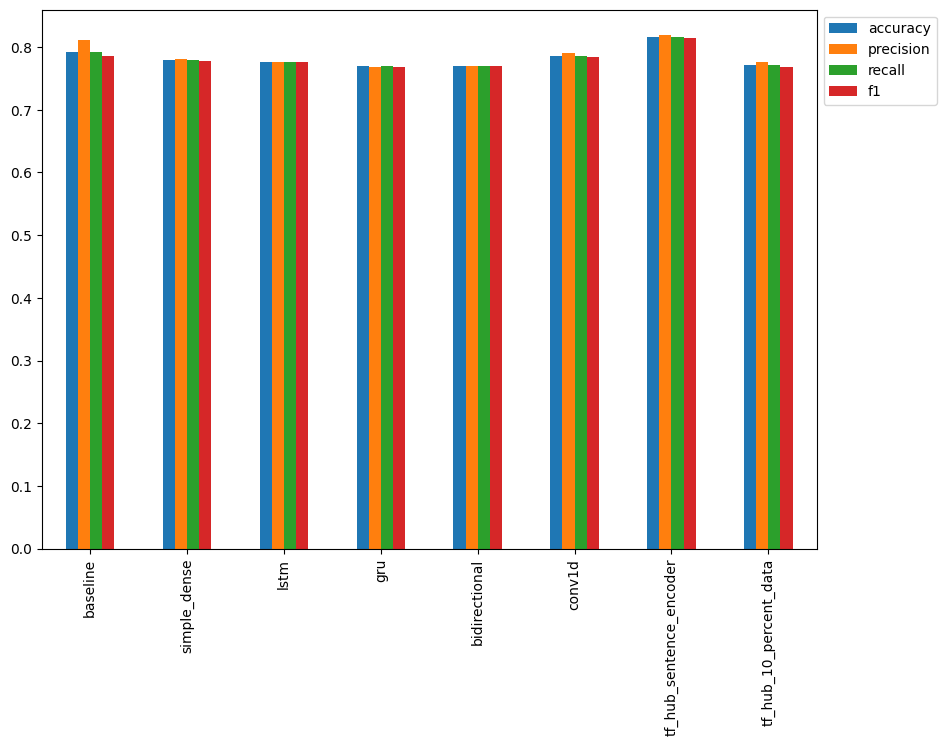

In [104]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

## Saving and laoding a trained model

There are two main formats to save a model to in Tensorflow:

1. the HDF5 format
2. the savemodel format 

In [105]:
model_6.save("model_6.h5")

In [106]:
import tensorflow_hub as hub
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [107]:
loaded_model_6.evaluate(val_sentences , val_labels)

24/24 [==============================] - 1s 17ms/step - loss: 0.4287 - accuracy: 0.8163


[0.4286760091781616, 0.8162729740142822]

In [108]:
model_6_results

{'accuracy': 81.62729658792651,
 'precision': 0.8187546712946793,
 'recall': 0.8162729658792651,
 'f1': 0.8147089025083661}

## Finding the most wrong examples

In [109]:
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_preds,
                       "pred_prob": tf.squeeze(model_6_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.145918
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747137
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.990194
3,@camilacabello97 Internally and externally scr...,1,0.0,0.209441
4,Radiation emergency #preparedness starts with ...,1,1.0,0.720666


In [110]:
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.921021
759,FedEx will no longer transport bioterror patho...,0,1.0,0.869275
628,@noah_anyname That's where the concentration c...,0,1.0,0.860720
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.853697
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.836854
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.804698
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.794710
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.792532
698,åÈMGN-AFRICAå¨ pin:263789F4 åÈ Correction: Ten...,0,1.0,0.784787
144,The Sound of Arson,0,1.0,0.771136


In [111]:
most_wrong.tail()

,text,target,pred,pred_prob
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.041575
38,Why are you deluged with low self-image? Take ...,1,0.0,0.041148
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.039820
233,I get to smoke my shit in peace,1,0.0,0.039066
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.038603


In [112]:
# Making predictions on the test dataset
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6.predict([test_sample])) # has to be list
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("----\n")

1/1 [==============================] - 0s 62ms/step
Pred: 0, Prob: 0.07044697552919388
Text:
RT #Target Best price on #Avril Crushed Sheer #CurtainPanel #Curtains #Decor #Blinds #Shades : http://t.co/TBhbuX6dc0

----

1/1 [==============================] - 0s 39ms/step
Pred: 0, Prob: 0.06297438591718674
Text:
I got my wisdom teeth out yesterday and I just demolished a whole bowl of chicken Alfredo like its nothing...

----

1/1 [==============================] - 0s 39ms/step
Pred: 1, Prob: 0.7425344586372375
Text:
here is goes again #abstorm #hailstorm #yychail stay safe everyone!

----

1/1 [==============================] - 0s 42ms/step
Pred: 0, Prob: 0.08967817574739456
Text:
@WilliamTCooper TY for the follow Go To http://t.co/l9MB2j5pXg BRUTALLY ABUSED+DESOLATE&amp;LOST + HER LOVELY MUM DIES..Is it Murder? Pls RT

----

1/1 [==============================] - 0s 95ms/step
Pred: 0, Prob: 0.05766475573182106
Text:
Reddit Will Now Quarantine Offensive Content via #Wired http://t.co/g8E

In [113]:
# Calculate the time of predictions
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.
  
  Args:
  ----
  model = a trained model
  sample = a list of samples

  Returns:
  ----
  total_time = total elapsed time for model to make predictions on samples
  time_per_pred = time in seconds per single sample
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time-start_time # calculate how long predictions took to make
  time_per_pred = total_time/len(val_sentences) # find prediction time per sample
  return total_time, time_per_pred

In [114]:
# Calculate TF Hub Sentence Encoder prediction times
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6, val_sentences)
model_6_total_pred_time, model_6_time_per_pred


24/24 [==============================] - 0s 12ms/step


(0.67488177100131, 0.0008856716154872834)

In [115]:
# Calculate Naive Bayes prediction times
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.05287501500060898, 6.938978346536612e-05)

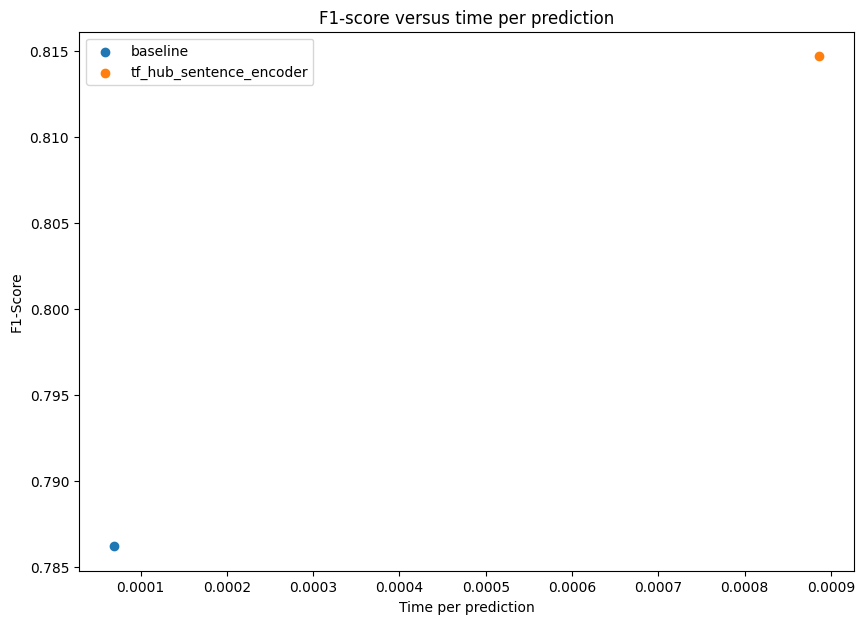

In [116]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-Score");